# IS Lab Micro Project
## Classification of Domestic Sounds

### Team Members: Nitin (CS18B012), Surya (CS18B035), Nagarjuna (CS18B018), Satya Sai (CS18B024)

## Importing Libraries

In [75]:
import librosa
import numpy as np
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import librosa.display
import warnings
import IPython.display as ipd
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.svm import SVC
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


warnings.filterwarnings("ignore")

NUM_OF_CLASSES = 4
cross_valid_accs = {}
test_accs = {}

## Data visualization

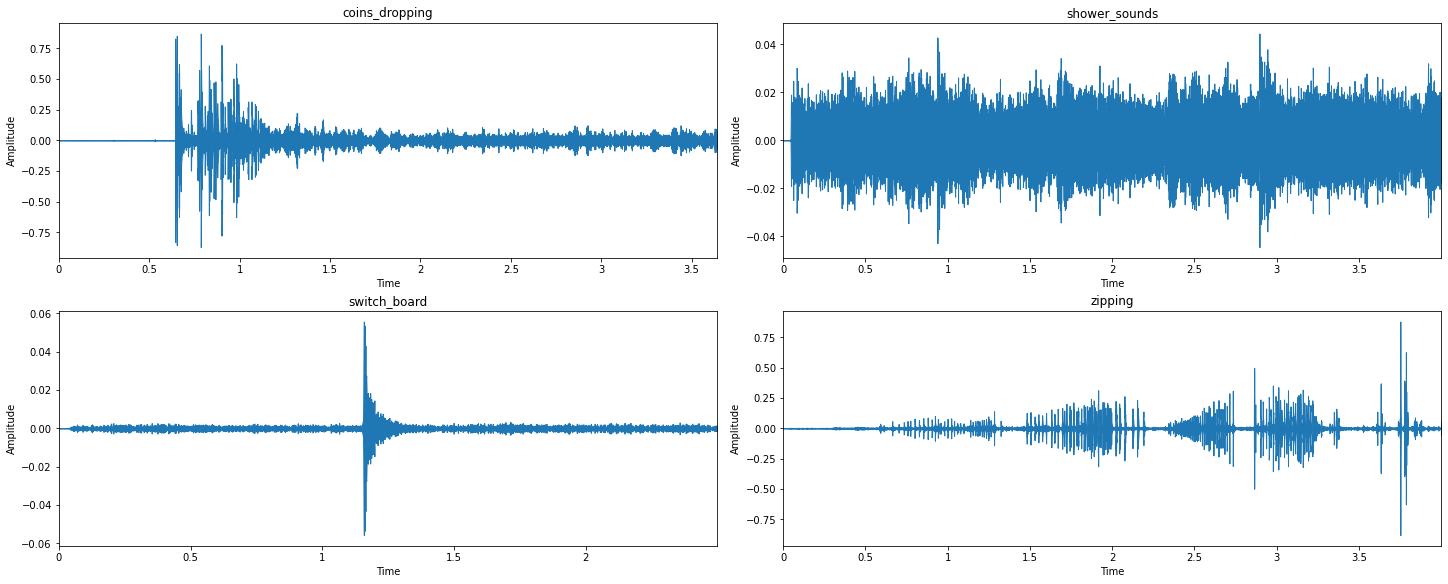

In [61]:
sample_audios = [["./dataset/coins_dropping/2021-11-26_152230729.wav","coins_dropping"],
                ["./dataset/shower_sounds/f4.wav","shower_sounds"],
                ["./dataset/switch_board/sw10.wav","switch_board"],
                ["./dataset/zipping/2021-11-26_122225688.wav","zipping"]]

f, ax = plt.subplots(2, 2, figsize=(20, 8), constrained_layout=True)
i=0
j=0
for audio in sample_audios:
    audio_data, sample_rate = librosa.load(audio[0], res_type='kaiser_fast', duration=4.0)
    librosa.display.waveplot(audio_data, sr=sample_rate, ax=ax[i,j])
    ax[i,j].set_title(audio[1])
    ax[i,j].set_ylabel("Amplitude")
    ax[i,j].set_xlabel("Time")
    
    if j == 0:
        j=j+1
    elif i == 0:
        j=0
        i=i+1

In [62]:
# Sample sounds
for audio in sample_audios:
    print("\033[1m" + audio[1] + "\033[0m")
    ipd.display(ipd.Audio(audio[0]))

coins_dropping


shower_sounds


switch_board


zipping


Text(0.5, 1.0, 'Class Distribution Plot')

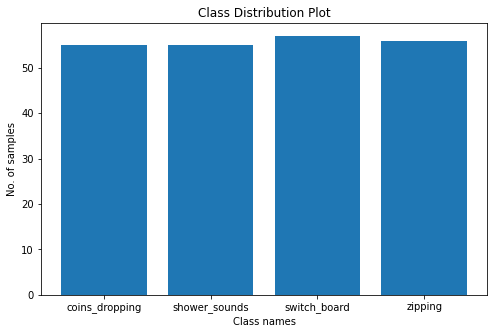

In [63]:
audio_dataset_path = "dataset/"

sub_dirs = [x[1] for x in os.walk(audio_dataset_path)][0]

classes = []
samples = []

for directory in sub_dirs:
    audio_path = os.path.join(os.path.abspath(audio_dataset_path), str(directory) + '/')
    audio_files = os.listdir(audio_path) 
    number_files = len(audio_files)
    classes.append(directory)
    samples.append(number_files)

fig = plt.figure(figsize = (8, 5))
plt.bar(classes, samples) 
plt.ylabel("No. of samples")
plt.xlabel("Class names")
plt.title("Class Distribution Plot")   


## Data Loading and Feature Engineering

In [64]:
def feature_extractor(file):
    audio_data, sample_rate = librosa.load(file, res_type='kaiser_fast', duration=4.0)
    
    # Pre-emphasising audio data 
    data = librosa.effects.preemphasis(audio_data) 
    
    # MFCC features
    mfcc_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=20)
    mfcc_features_mean = np.mean(mfcc_features.T, axis=0)
    mfcc_features_std = np.std(mfcc_features.T, axis=0)
    
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(data))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(data, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    contrast_std = np.std(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)    

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data),
    sr=sample_rate).T,axis=0)
        
    # Concatenating only MFCC, chroma and spectral contrast features 
    # since they are most useful features for domestic sounds classification
    
    features = np.concatenate((mfcc_features_mean, mfcc_features_std, chroma, chroma_std, contrast, contrast_std), axis=0)
    
    return features

In [65]:
audio_dataset_path = "dataset/"

extracted_features = []
# getting the class labels by reading names of sub directories
sub_dirs = [x[1] for x in os.walk(audio_dataset_path)][0]

print('Loading audio files from dataset folder:')

for directory in sub_dirs:
    audio_path = os.path.join(os.path.abspath(audio_dataset_path), str(directory) + '/')
    print(audio_path)

    # Reading all audio .wav files present in a folder 
    for file in glob.glob(audio_path + "*.wav"):
        label = directory
        data = feature_extractor(file)
        extracted_features.append([data, label])

Loading audio files from dataset folder:
E:\SEM-7\IS Lab\micro_project\dataset\coins_dropping/
E:\SEM-7\IS Lab\micro_project\dataset\shower_sounds/
E:\SEM-7\IS Lab\micro_project\dataset\switch_board/
E:\SEM-7\IS Lab\micro_project\dataset\zipping/


In [66]:
feat = []
for i in extracted_features:
    j = list(i[0])
    
    j.append(i[1])
    feat.append(j)

df = pd.DataFrame(feat)

In [67]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,-374.251343,-21.518492,-114.677475,32.554348,-24.836382,7.702024,-14.132204,14.440598,-23.690212,5.073739,...,18.679502,36.375772,3.873062,3.016834,2.914683,2.439595,1.987400,1.910344,3.436826,coins_dropping
1,-475.474274,-24.684605,-82.840141,35.057076,-23.336338,2.205986,1.099004,5.166961,-27.598701,7.360845,...,19.098137,33.179017,3.761037,3.715577,3.374721,2.595265,3.296630,3.056207,3.101249,coins_dropping
2,-442.522217,-23.528774,-91.016380,44.506393,-24.207815,-3.581905,-15.582358,7.107831,-19.306219,13.301052,...,20.031166,34.038885,3.563190,3.818298,2.826984,2.270575,1.667703,3.096744,3.105471,coins_dropping
3,-309.469604,-40.026241,-100.127281,37.720726,-38.224987,-1.387837,-13.544527,13.186404,-25.365900,11.688083,...,18.773481,33.160151,3.792046,3.066032,3.196635,2.115297,2.132072,2.398688,2.935120,coins_dropping
4,-307.692780,-33.991432,-99.421097,38.636284,-37.379677,3.618627,-9.663276,13.404822,-20.145592,13.539990,...,19.018198,34.565853,3.858435,3.185971,3.652195,2.127883,1.968170,1.935069,3.487497,coins_dropping


## Data Cleaning

In [68]:
values_list = list()
cols_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
pct_missing_df = pd.DataFrame()
pct_missing_df['col'] = cols_list
pct_missing_df['pct_missing'] = values_list

In [69]:
# Removing missing values with more than 40% NULLs

_40_pct_missing_cols_list = list(pct_missing_df.loc[pct_missing_df.pct_missing > 40, 'col'].values)
df.drop(columns=_40_pct_missing_cols_list, inplace=True)

In [70]:
df.isnull().sum().sum()

0

In [71]:
# Removing duplicate records

cols = list(df.columns)
df.drop_duplicates(subset=cols, inplace=True)

## Clustering

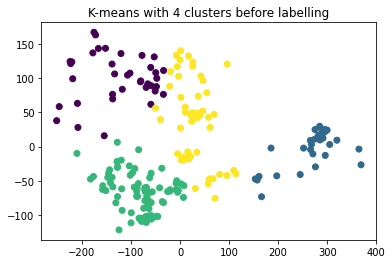

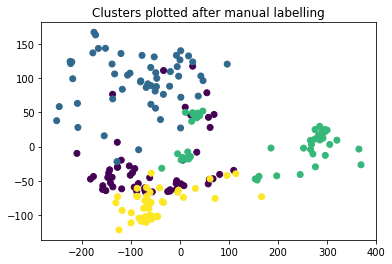

In [72]:
train_x = df.drop(78, axis=1)
train_y = df[78]

le = LabelEncoder()
train_y2 = le.fit_transform(train_y)

pca = PCA(n_components = 2).fit(train_x)
pca_2d = pca.transform(train_x)

kmeans = KMeans(n_clusters=4, max_iter=800, algorithm='auto', random_state=111)
kmeans.fit(train_x)
pl.figure('K-means with 4 clusters before labelling')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.title('K-means with 4 clusters before labelling')


pl.figure('Referance plot')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=train_y2)
pl.title('Clusters plotted after manual labelling')


pl.show()

In [77]:
print("homogeneity and completeness and V-Measure Scores:")
homogeneity_completeness_v_measure(kmeans.labels_, train_y2)

homogeneity and completeness and V-Measure Scores:


(0.49144503313047044, 0.4710176676096293, 0.4810145745605556)

In [15]:
X = df.iloc[:,:78]
y = df[78]

## Categorical Encoding

In [16]:
le = LabelEncoder()
yy = le.fit_transform(y)

## Splitting into train and test

In [17]:
# Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X, yy ,test_size=0.4,random_state=0)

In [18]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(127, 78)
(85, 78)
(127,)
(85,)


## Building Classifier model

### ANN Model

In [20]:
def get_model(inp_shape=78, num_labels=4, hidden_layer1=200, 
              hidden_layer2=300, hidden_layer3=200, dropout=0.5, learnRate=0.01):
    model=Sequential()
    ###first layer
    model.add(Dense(hidden_layer1,input_shape=(inp_shape,)))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    ###second layer
    model.add(Dense(hidden_layer2))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    ###third layer
    model.add(Dense(hidden_layer3))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))

    ###final layer
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=learnRate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    
    return model

In [21]:
model = KerasClassifier(build_fn=get_model, verbose=0)

In [22]:
hidden_layer1=[100, 150, 200]
hidden_layer2=[150, 200, 300]
hidden_layer3=[100, 150, 200]
dropout=[0.3, 0.4, 0.5]
learnRate=[1e-2, 1e-3, 1e-4]
epochs = [20, 30, 40, 50]

grid = dict(
    hidden_layer1= hidden_layer1,
    hidden_layer2= hidden_layer2,
    hidden_layer3= hidden_layer3,
    dropout= dropout,
    learnRate= learnRate,
    epochs = epochs
)

### Cross validation for Hyper parameter tuning

In [23]:
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                            param_distributions=grid, scoring="accuracy", verbose=1)
searchResults = searcher.fit(X_train, y_train)

bestParams = searchResults.best_params_
print("The best params are: \n {}".format(bestParams))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best params are: 
 {'learnRate': 0.01, 'hidden_layer3': 150, 'hidden_layer2': 150, 'hidden_layer1': 200, 'epochs': 50, 'dropout': 0.3}


In [24]:
bestModel = searchResults.best_estimator_

scores = cross_val_score(bestModel, X_train, y_train, cv=5)
mean_acc = np.mean(scores)*100
print("Cross validation accuracy on Train set: {:.2f}%".format(mean_acc))
cross_valid_accs["ANN"] =  mean_acc

Cross validation accuracy on Train set: 93.78%


In [25]:
accuracy = bestModel.score(X_test, y_test)
print("Accuracy on Test set: {:.2f}%".format(accuracy * 100))
test_accs["ANN"] = accuracy*100

Accuracy on Test set: 96.47%


## PR Curve

In [26]:
def pr_curve(model):
    model_probs = model.predict_proba(X_test)
    precision = dict()
    recall = dict()
    for i in range(NUM_OF_CLASSES):
        precision[i], recall[i], _ = precision_recall_curve(y_test_categorical[:,i],
                                                            model_probs[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=le.classes_[i])
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs Recall Curve")
    plt.show()

Instructions for updating:
Please use `model.predict()` instead.


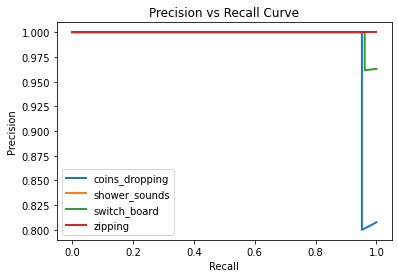

In [27]:
pr_curve(bestModel)

Observations:
* Zipping class has more AUC in precision vs recall compared to other classes.
* We can see that coin_dropping class has dropped in terms of precision when recall is high. 

## ROC Curve

In [28]:
def roc_curve_(model):
    model_probs = model.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    for i in range(NUM_OF_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], model_probs[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label=le.classes_[i])

    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend(loc="best")
    plt.title("ROC Curve")
    plt.show()

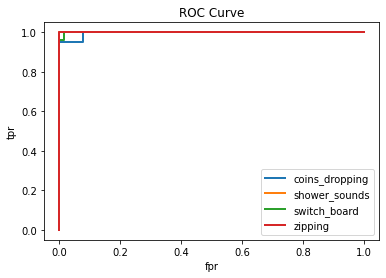

In [29]:
roc_curve_(bestModel)

Observations:
* The area under the curve(AUC) is high for zipping and shower_sounds which implies that the ability of the classifier to distinguish these classes is more.

## AUC Score

In [30]:
def auc_score_(model):
    print("AUC Score per class:\n")
    model_probs = model.predict_proba(X_test)
    for i in range(NUM_OF_CLASSES):
        auc_score = roc_auc_score(y_test_categorical[:,1], model_probs[:,1])
        print(le.classes_[i], auc_score)

In [31]:
auc_score_(bestModel)

AUC Score per class:

coins_dropping 1.0
shower_sounds 1.0
switch_board 1.0
zipping 1.0


## Comapring multiple classifiers

### Random Forest Classifier

In [32]:
# Considering these hyper parameters
criterion=['gini','entropy']
n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
max_depth = [int(x) for x in np.linspace(5, 55, 11)]

hyper_parameters = dict(criterion = criterion, n_estimators= n_estimators, max_depth= max_depth)

### Cross validation for Hyper parameter tuning

In [33]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = hyper_parameters, 
                               n_iter = 200, cv = 5, verbose = 2, random_state = 42, scoring="accuracy",
                               n_jobs = -1)

In [34]:
search = rf_random.fit(X_train,y_train)
search.best_params_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


{'n_estimators': 200, 'max_depth': 55, 'criterion': 'gini'}

In [35]:
bestModel = search.best_estimator_

In [36]:
scores = cross_val_score(bestModel, X_train, y_train, cv=5)
mean_acc = np.mean(scores)*100
print("Cross validation accuracy on Train set: {:.2f}%".format(mean_acc))
cross_valid_accs["Random Forest"] = mean_acc

Cross validation accuracy on Train set: 95.35%


In [37]:
accuracy = bestModel.score(X_test, y_test)
print("Accuracy on Test set: {:.2f}%".format(accuracy * 100))
test_accs["Random Forest"] = accuracy*100

Accuracy on Test set: 98.82%


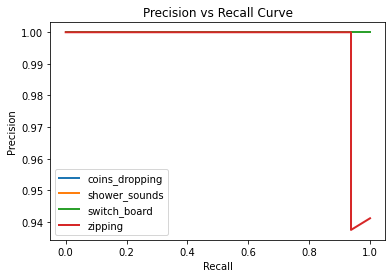

In [38]:
pr_curve(bestModel)

Observations:
* Except for Zipping class, all other classes have more AUC in precision vs recall curve.
* We can see that zipping class has dropped in terms of precision when recall is high. 

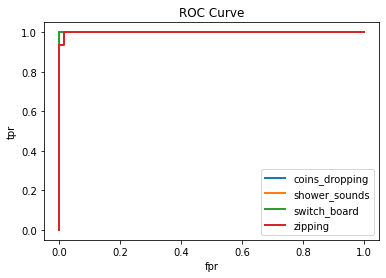

In [39]:
roc_curve_(bestModel)

Observations:
* For all the classes the AUC is 1 approx which means the classifier is able to perfectly distinguish between all classes correctly
* Since it has high AUC for all classes compared to other classifiers, the performance of this model on test data set is high (we can observe the same from the accuracy plots on test set) 

In [40]:
auc_score_(bestModel)

AUC Score per class:

coins_dropping 1.0
shower_sounds 1.0
switch_board 1.0
zipping 1.0


### Logistic Regression

In [41]:
penalty = ['l1', 'l2']
C = np.logspace(-4,4,50)
max_iter = [200, 400, 600, 800, 1000]

hyper_parameters = dict(penalty = penalty, C=C, max_iter=max_iter)

### Cross validation for Hyper parameter tuning

In [42]:
rf_random = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions = hyper_parameters, 
                               n_iter = 200, cv = 5, verbose = 2, random_state = 42, scoring="accuracy",
                               n_jobs = -1)

In [43]:
search = rf_random.fit(X_train,y_train)
search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'penalty': 'l2', 'max_iter': 800, 'C': 2.559547922699533}

In [44]:
bestModel = search.best_estimator_

scores = cross_val_score(bestModel, X_train, y_train, cv=5)
mean_acc = np.mean(scores)*100
print("Cross validation accuracy on train set: {:.2f}%".format(mean_acc))
cross_valid_accs["Logistic Regression"] = mean_acc

Cross validation accuracy on train set: 96.09%


In [45]:
accuracy = bestModel.score(X_test, y_test)
print("Accuracy on Test set: {:.2f}%".format(accuracy * 100))
test_accs["Logistic Regression"] = accuracy*100

Accuracy on Test set: 98.82%


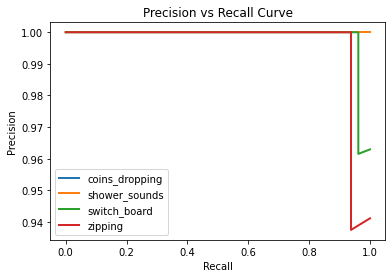

In [46]:
pr_curve(bestModel)

Observations:
* shower_sounds and coin_dropping classes have more AUC in precision vs recall compared to other classes.
* We can see that zipping, switch_board classes has dropped in terms of precision when recall is high. 

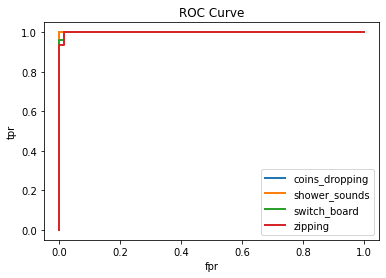

In [47]:
roc_curve_(bestModel)

Observations:
* For all the classes the AUC is 1 approx which means the classifier is able to perfectly distinguish between all classes correctly
* Since it has high AUC for all classes compared to other classifiers, the performance of this model on test data set is high (we can observe the same from the accuracy plots on test set) 

In [48]:
auc_score_(bestModel)

AUC Score per class:

coins_dropping 1.0
shower_sounds 1.0
switch_board 1.0
zipping 1.0


### SVM

In [49]:
C = np.logspace(-4,4,50)
gamma = np.logspace(-4, -3, 50)
kernel= ['rbf', 'linear', 'poly', 'sigmoid']
class_weight = ['balanced', None]
max_iter = [200, 400, 600, 800, 1000]

hyper_parameters = dict(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight, max_iter=max_iter)

### Cross validation for Hyper parameter tuning

In [50]:
rf_random = RandomizedSearchCV(estimator = SVC(probability=True), param_distributions = hyper_parameters, 
                               n_iter = 200, cv = 5, verbose = 2, random_state = 42, scoring="accuracy",
                               n_jobs = -1)

In [51]:
search = rf_random.fit(X_train,y_train)
search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'max_iter': 1000,
 'kernel': 'rbf',
 'gamma': 0.00012648552168552957,
 'class_weight': None,
 'C': 494.1713361323828}

In [52]:
bestModel = search.best_estimator_

scores = cross_val_score(bestModel, X_train, y_train, cv=5)
mean_acc = np.mean(scores)*100
print("Cross validation accuracy on train set: {:.2f}%".format(mean_acc))
cross_valid_accs["SVM"] = mean_acc

Cross validation accuracy on train set: 97.66%


In [53]:
accuracy = bestModel.score(X_test, y_test)
print("Accuracy on Test set: {:.2f}%".format(accuracy * 100))
test_accs["SVM"] = accuracy*100

Accuracy on Test set: 95.29%


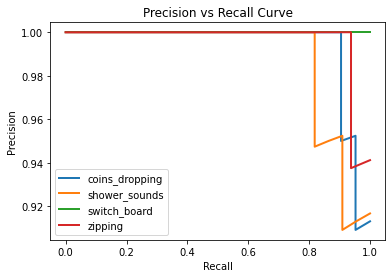

In [54]:
pr_curve(bestModel)

Observations:
* switch_board class has more AUC in precision vs recall compared to other classes.
* We can see that coin_dropping, shower_sounds, zipping classes have dropped in terms of precision when recall is high. 

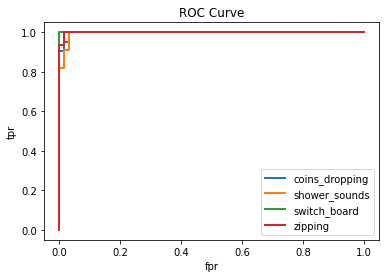

In [55]:
roc_curve_(bestModel)

Observations:
* The area under the curve(AUC) is high for switch_board compared to other classes which implies that the ability of the classifier to distinguish this class is more.
* Since it has low AUC for 3 out of 4 classes compared to other classifiers, the performance of this model on test data set is low (we can observe the same from the accuracy plots on test set) 

In [56]:
auc_score_(bestModel)

AUC Score per class:

coins_dropping 0.9956709956709957
shower_sounds 0.9956709956709957
switch_board 0.9956709956709957
zipping 0.9956709956709957


## Refined output score plots after post processing

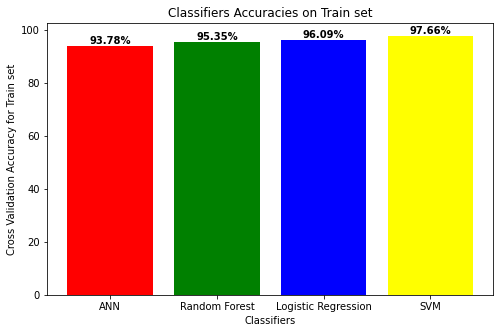

In [57]:
fig = plt.figure(figsize = (8, 5))
accs = list(cross_valid_accs.values())
graph = plt.bar(list(cross_valid_accs.keys()), list(cross_valid_accs.values()), color=["red","green","blue","yellow"]) 
plt.ylabel("Cross Validation Accuracy for Train set")
plt.xlabel("Classifiers")
plt.title("Classifiers Accuracies on Train set")   

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(round(accs[i],2))+'%',
             ha='center',
             weight='bold')
    i += 1
plt.show()

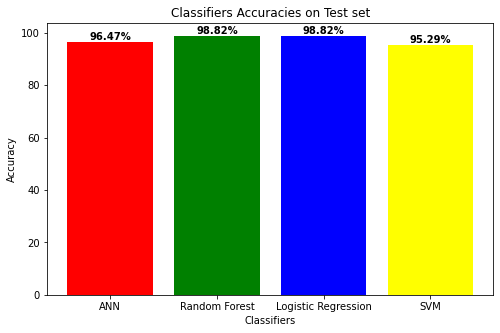

In [58]:
fig = plt.figure(figsize = (8, 5))
accs = list(test_accs.values())
graph = plt.bar(list(test_accs.keys()), list(test_accs.values()), color=["red","green","blue","yellow"]) 
plt.ylabel("Accuracy")
plt.xlabel("Classifiers")
plt.title("Classifiers Accuracies on Test set")   

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(round(accs[i],2))+'%',
             ha='center',
             weight='bold')
    i += 1
plt.show()

Observations:
* Comparing all the classifiers, random forest and logistic regression gave higher accuracy on the test dataset.
* Comparing all the classifiers, SVM gave higher cross validation accuracy on the train dataset.